# Ford GoBike Dataset Analysis
## by Janani R

## Investigation Overview

Among other features such as age, gender and locations, the primary feature of interest was trip duration.


## Dataset Overview

Each trip is anonymized and includes:

1. Trip Duration (seconds)<br>
2. Start Time and Date<br>
3. End Time and Date<br>
4. Start Station ID<br>
5. Start Station Name<br>
6. Start Station Latitude<br>
7. Start Station Longitude<br>
8. End Station ID<br>
9. End Station Name<br>
10. End Station Latitude<br>
11. End Station Longitude<br>
12. Bike ID<br>
13. User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)<br>
14. Member Year of Birth<br>
15. Member Gender

There were 519700 records in which high amount of variation existed with respect to duration with a standard deviation of 3444. But 75% of the values lied below 1000 which was considered while trimming outliers. 

In [10]:
# import all packages and set plots to be embedded inline
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from geopy.distance import geodesic 
from scipy import stats

%matplotlib inline

warnings.filterwarnings('ignore')

In [11]:
# load in the dataset into a pandas dataframe
bikes = pd.read_csv("2017-fordgobike-tripdata.csv")

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Univariate Exploration of Trip Duration

Since most of the values seemed to lie below 4000, I removed the outliers. For this, I computed the Z score of each duration value and remove it if was below 3. That is, remove all values beyond two standard deviations. <a href="https://www.investopedia.com/terms/z/zscore.asp">More Info</a>

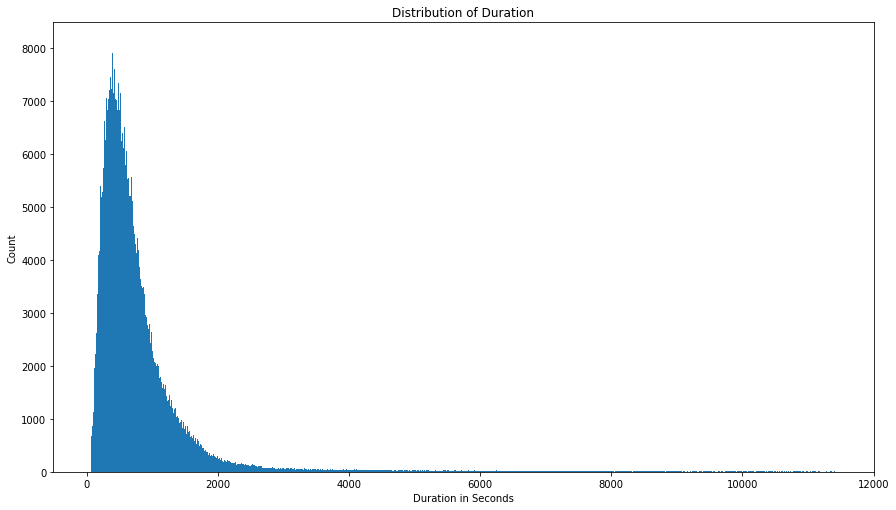

In [12]:
# Removing the outliers
bikes = bikes[(np.abs(stats.zscore(bikes.duration_sec)) < 3)]

# Visualization
graph = bikes.duration_sec
plt.figure(figsize=[14.70, 8.27])
plt.hist(graph,bins=1000);
plt.title("Distribution of Duration")
plt.xlabel('Duration in Seconds')
plt.ylabel('Count');

## The effect of User Type on Trip Duration

This visualization represents the relationship between User Type and Trip Duration, indicating that regular users take lesser time to complete rides.

In [13]:
# Setting the base color
base_color = sns.color_palette()[0]

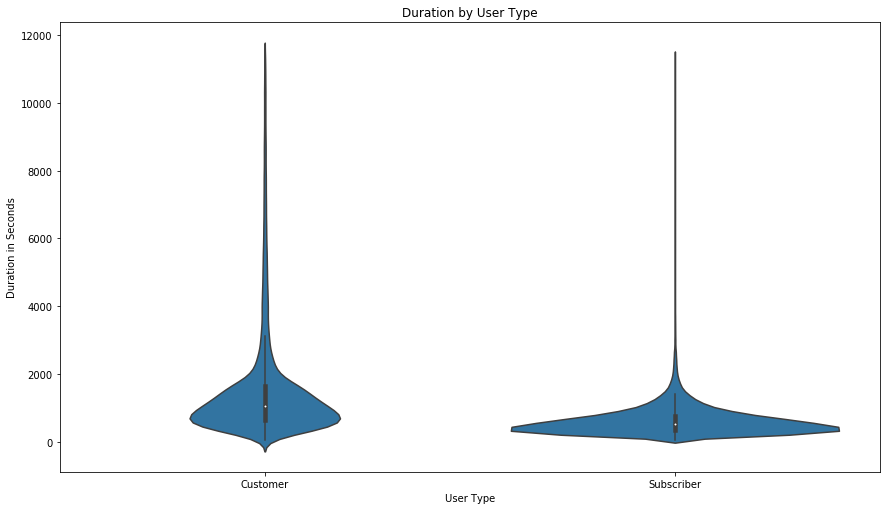

In [14]:
# User Type and Duration
plt.figure(figsize=[14.70, 8.27])
sns.violinplot(data=bikes,x='user_type',y='duration_sec', color=base_color);
plt.title("Duration by User Type")
plt.xlabel('User Type')
plt.ylabel('Duration in Seconds');

## Duration vs Start Hour (with respect to top start-end locations)

Considering only the top locations in which trips most commonly start and end, I plotted the relationship between duration and start hour overall and then per start to end location. Both reflected that more time was taken during daytime, presumably due to higher traffic.

In [15]:
# Date columns which are strings need to be converted
def strip_time(date):
    return datetime.strptime(date,'%Y-%m-%d %H:%M:%S.%f')

bikes['start_t'] = bikes.start_time.apply(lambda x:strip_time(x))
bikes['end_t'] = bikes.end_time.apply(lambda x:strip_time(x))

# Create separate columns for all attributes of date for every date column
def convert_timestamp_to_attributes(df):
    for date_column in df.columns.values:
        df[date_column+'_day'] = df[date_column].apply(lambda x:x.day)
        df[date_column+'_dayofweek'] = df[date_column].apply(lambda x:x.dayofweek)
        df[date_column+'_dayname'] = df[date_column].apply(lambda x:x.strftime('%a'))
        df[date_column+'_dayofyear'] = df[date_column].apply(lambda x:x.dayofyear)
        df[date_column+'_hour'] = df[date_column].apply(lambda x:x.hour)
        df[date_column+'_month'] = df[date_column].apply(lambda x:x.month)
        df[date_column+'_weekofyear'] = df[date_column].apply(lambda x:x.weekofyear)
        df[date_column+'_year'] = df[date_column].apply(lambda x:x.year)
    return df

def convert_df_to_timedf(df):
    time_df = df.select_dtypes(include=[np.datetime64])
    return df.merge(convert_timestamp_to_attributes(time_df))

bikes = convert_df_to_timedf(bikes)

In [16]:
# Create a new surrogate key for the dataframe
bikes['trip_id'] = bikes.apply(lambda x:str(x.bike_id)+'_'+x.start_time,axis=1)

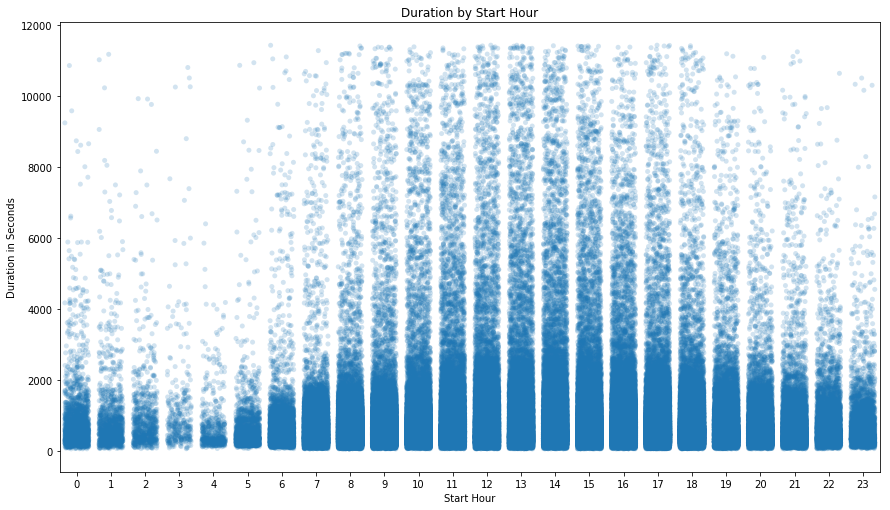

In [20]:
# Duration vs Start Hour
plt.figure(figsize=[14.70, 8.27])
sns.stripplot(data = bikes, x='start_t_hour', y='duration_sec', alpha=0.2, jitter=0.35, color=base_color);
plt.xlabel('Start Hour')
plt.ylabel('Duration in Seconds')
plt.title("Duration by Start Hour");

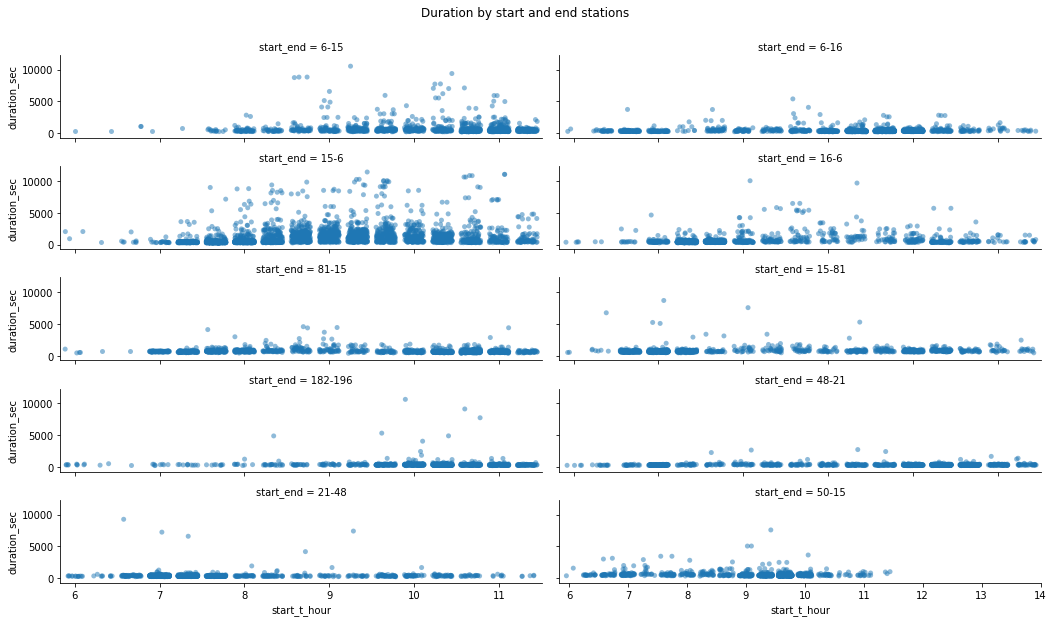

In [19]:
# Create key to capture start and end locations
bikes['start_end'] = bikes.apply(lambda x:str(x['start_station_id'])+'-'+str(x['end_station_id']),axis=1)

# Find commonly trafficked start and end locations
top_locations = list(bikes.groupby(['start_end'])['trip_id'].count().sort_values(ascending=False)[:10].index.values)

# Plot the trips only for such locations
tripdata_by_location = bikes[bikes.start_end.isin(top_locations)]
g = sns.FacetGrid(data=tripdata_by_location, col='start_end',col_wrap=2,height=(8.27/5),aspect=(14.7/2)/(8.27/5))
g.map(sns.stripplot,'start_t_hour', 'duration_sec',alpha=0.5,jitter=0.35);
plt.suptitle("Duration by start and end stations", y = 1.04)
plt.tight_layout()
plt.xticks(np.arange(0,25,3));

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!